In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from scipy import stats
import itertools
import warnings


pd.set_option('display.float_format', lambda x: '{:.5f}'.format(x))

::

    Number of observations: 2225
    Number of variables: 2
    Variable name definitions:

        date - sample date in YYMMDD format
        co2 - CO2 Concentration ppmv

    The data returned by load_pandas contains the dates as the index.



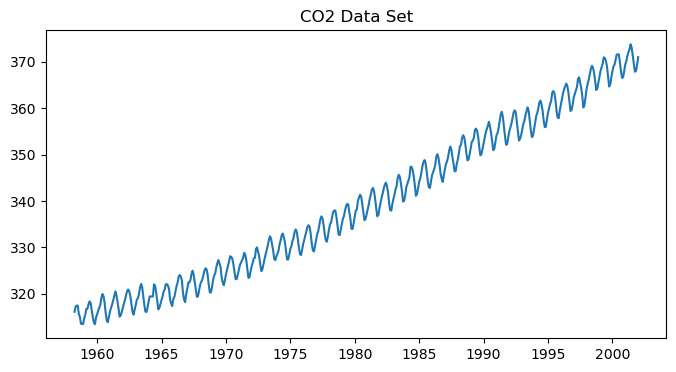

,co2
1958-03-31,316.10000
1958-04-30,317.20000
1958-05-31,317.43333
1958-06-30,317.43333
1958-07-31,315.62500
1958-08-31,314.95000
1958-09-30,313.50000
1958-10-31,313.50000
1958-11-30,313.42500
1958-12-31,314.70000


In [2]:
# co2 data
co2 = sm.datasets.co2.load_pandas().data.resample('ME').mean().ffill()
print(sm.datasets.co2.NOTE)

plt.figure(figsize=(8,4))
plt.plot(co2.co2)
plt.title('CO2 Data Set')
plt.show()

co2.head(10)

In [3]:
class ARIMA_Simul:
    def __init__(self, time_series):
        self.time_series = time_series

    """
    ARIMA time-series forecasting
    - user-controlled differencing
    - iterative model selection (AIC & p-val)
    - empirical noise distribution
    - simulation generation

    Methods:
    ----------
    check_stationarity(self, signif_: float, plot_: bool):
        Checks if a series is stationary using Dickney-Fuller test
        Optional - plot ACF/PACF

    difference_series(self, order = 1, rmv_season = None):
        Differences the series with order 1 unless rmv_season. Then with order rmv_season
        Updates the class 

    stationarity_iter(signif_: float):
        Iteration tool to difference until dfuller test is significant (max 5 iterations)

    run_ARIMA(self, order):
        Run statsmodels ARIMA

    evaluate_arima_models(self, p_range: list, q_range: list):
        Minimise AIC for models in (p x 0 x q)
    
    remove_p_val(self, p_range, q_range, signif_ = 0.05):
        Remove p < signif_ from best candidate from evaluate_arima_models
        e.g.: remove_p_val(list(range(1,4)), list(range(1,9)))
    
    n_forecasts(n_sim, m_periods):
        Create n_sim simulations of length m_periods
        Use empirical noise distribution
        Optional plot forecasts

    exceedance_prob(forecasts, threshold):
        % simulations (mean + white noise) > threshold in each period
    
    -------
    """

    def check_stationarity(self, signif_: float, plot_: bool):
        result = adfuller(self.time_series)
        p_value = result[1]
        # autocorr_ = self.time_series.autocorr()
        # print(f"Autocorrelation: {autocorr_}")

        if plot_:
            fig, axs = plt.subplots(2, 2, figsize=(14, 10))
            axs[0, 0].plot(self.time_series)
            axs[0, 0].set_title(f"Time Series\nAdfuller p-value: {np.round(p_value, 5)}")
            axs[0, 0].set_xlabel("Time")
            axs[0, 0].set_ylabel("Value")

            # ACF Plot
            plot_acf(self.time_series, ax=axs[1, 0], lags=40, alpha = 0.01)
            axs[1, 0].set_title("Autocorrelation Function (ACF)")

            # PACF Plot
            plot_pacf(self.time_series, ax=axs[1, 1], lags=40, alpha = 0.01)
            axs[1, 1].set_title("Partial Autocorrelation Function (PACF)")

            axs[0, 1].axis('off')

            # Adjust layout
            plt.tight_layout()
            plt.show()
        
        return p_value < signif_

    def difference_series(self, order = 1, rmv_season = None):
        order = rmv_season if rmv_season is not None else order
        self.time_series = self.time_series.diff(order).dropna()

        print(order)

    def stationarity_iter(self, signif_: float):
        max_iter = 5
        n = 0

        while not self.check_stationarity(signif_= signif_, plot_=True):

            if n > max_iter:
                break
                
            # Apply differencing
            self.difference_series(order = 1)
        
            # Increment the iteration counter
            n += 1

    def evaluate_arima_models(self, p_range, q_range):
        best_aic = float('inf')
        best_model = None
        best_params = None

        pdq = list(itertools.product(p_range, [0], q_range))

        for param in pdq:
            # print(param)
            # print(best_aic)
            try:
                with warnings.catch_warnings():
                    warnings.filterwarnings("ignore")
                    # model = ARIMA(self.time_series, order=param)
                    # model_fit = model.fit()
                    model_fit = self.run_ARIMA(order = param)

                if model_fit.aic < best_aic:
                    best_aic = model_fit.aic
                    best_model = model_fit
                    best_params = param
            except:
                continue

        return best_model, best_params

    def run_ARIMA(self, order):
        model = ARIMA(self.time_series, order=order).fit()
        return model

    def remove_p_val(self, p_range: list, q_range: list, signif_ = 0.05):
        best_model, params = self.evaluate_arima_models(p_range, q_range)
        full_model_aic = best_model.aic
        
        while True:
            p, d, q = params
            p_values = best_model.pvalues[1:]

            max_p_val = max(p_values)
            if max_p_val <= signif_:
                break

            max_p_index = p_values.argmax()
            # print(max_p_index)

            if max_p_index < p:
                p_range.pop(max_p_index)
            else:
                q_range.pop(max_p_index - p)

            best_model = self.run_ARIMA(order = (p_range, 0, q_range))
            print(f"""Iteration AIC: {best_model.aic} vs. full model AIC: {full_model_aic}""")
            params = (len(p_range), 0, len(q_range))
        
        self.model = best_model
        return best_model

    def fit_noise_dist(self):
        if self.model is None:
            raise ValueError("Model has not been fitted.")
        resid = np.array(self.model.resid)
        kde_ = stats.gaussian_kde(resid)
        self.kde = kde_

    def get_forecast(self, n_periods):
        if self.model is None:
            raise ValueError("Model has not been fitted.")
        future = self.model.forecast(n_periods)
        return future

    def plot_forecasts(self, forecasts):
        max_to_plot = 10
        data = forecasts
        x = np.arange(data.shape[1])
        for i, row in enumerate(data):
            if i < max_to_plot:
                plt.plot(x, row, label=f'Row {i+1}')

    def n_forecasts(self, n_sim, n_periods, plot_sample:bool):
        if self.model is None:
            raise ValueError("Model has not been fitted.")
            
        self.fit_noise_dist()
        forecasts = []
        for i in range(0, n_sim):
            kde_noise = self.kde.resample(n_periods)[0]
            predicted_mean = self.get_forecast(n_periods = n_periods).values
            forecasts.append(predicted_mean + kde_noise)

        forecasts = np.array(forecasts)

        if plot_sample:
            self.plot_forecasts(forecasts)
            
        return forecasts

    def exceedance_prob(self, forecasts, threshold):
        return (forecasts > threshold).mean(axis=1)
            

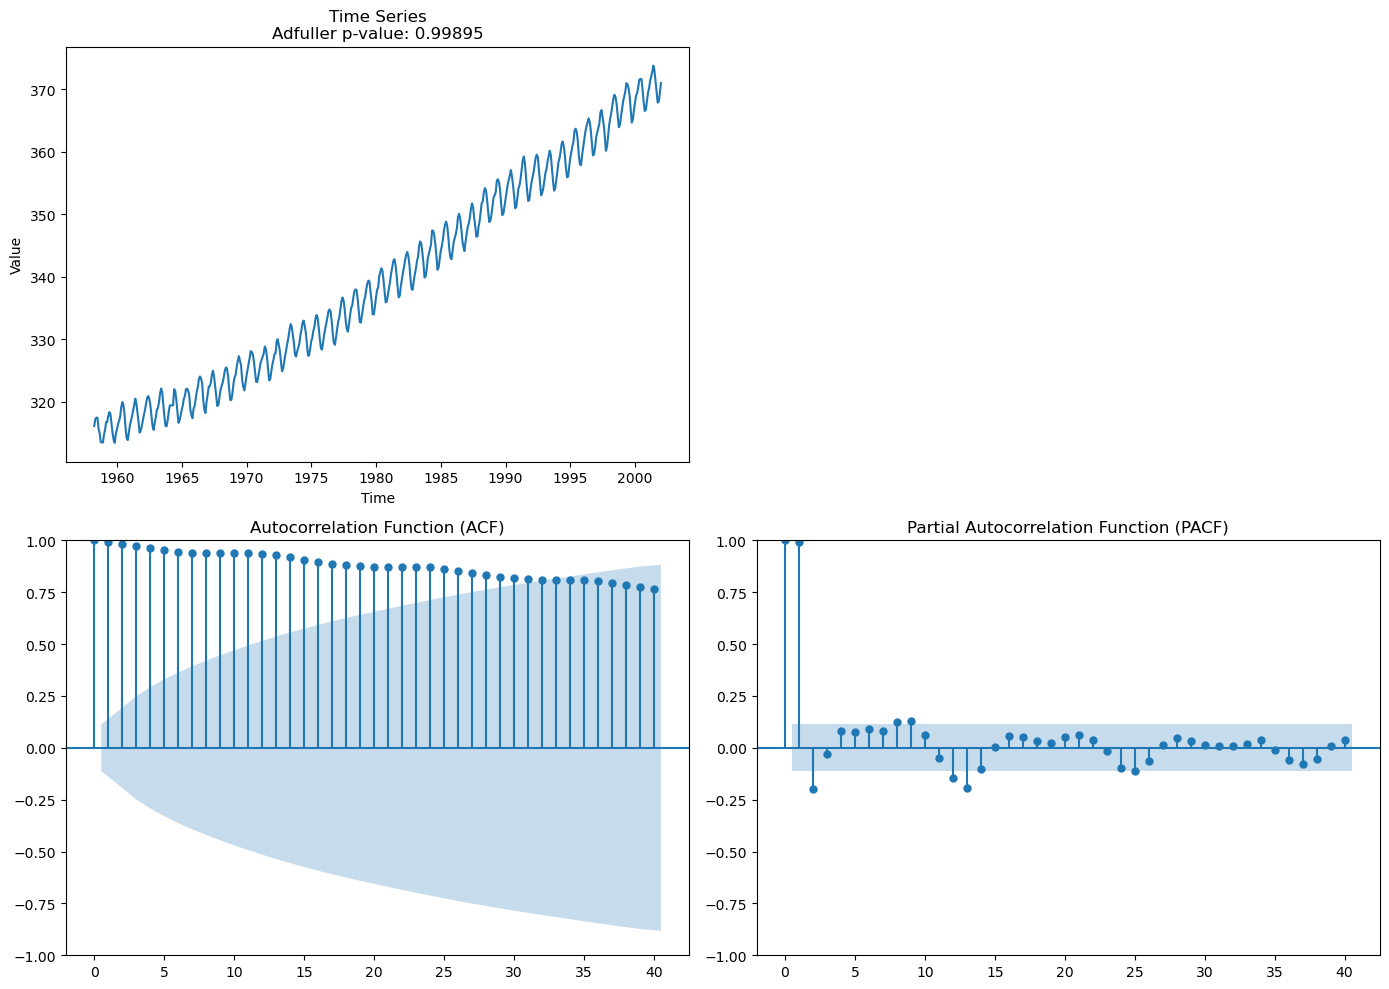

1


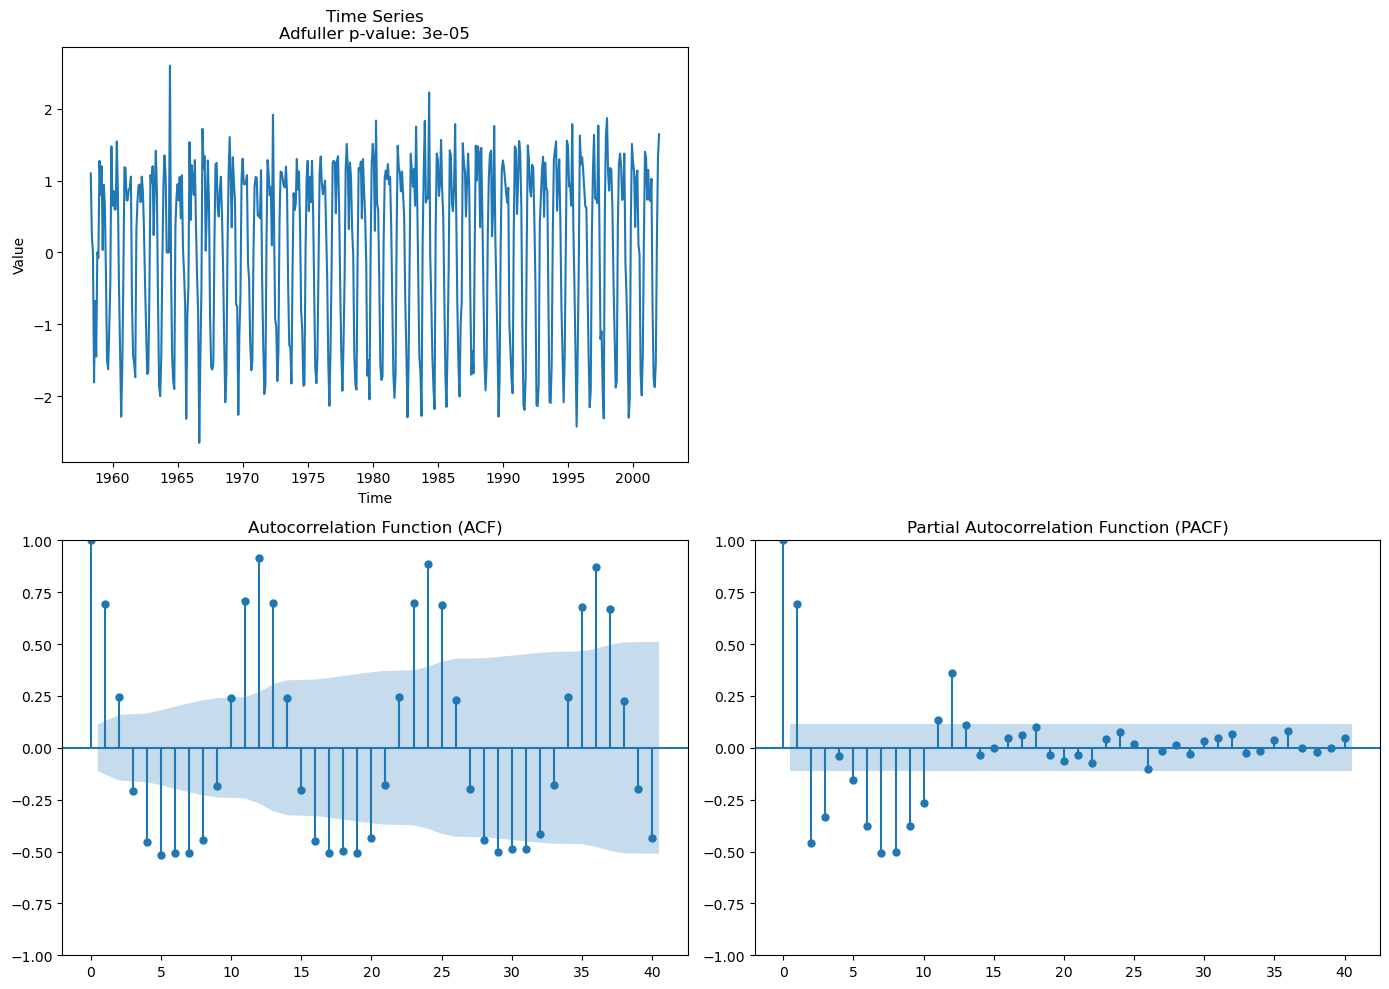

In [4]:
ts_analyser = ARIMA_6pc(co2.co2)
ts_analyser.stationarity_iter(0.01) # difference until stationary (Dickney-Fuller)

12


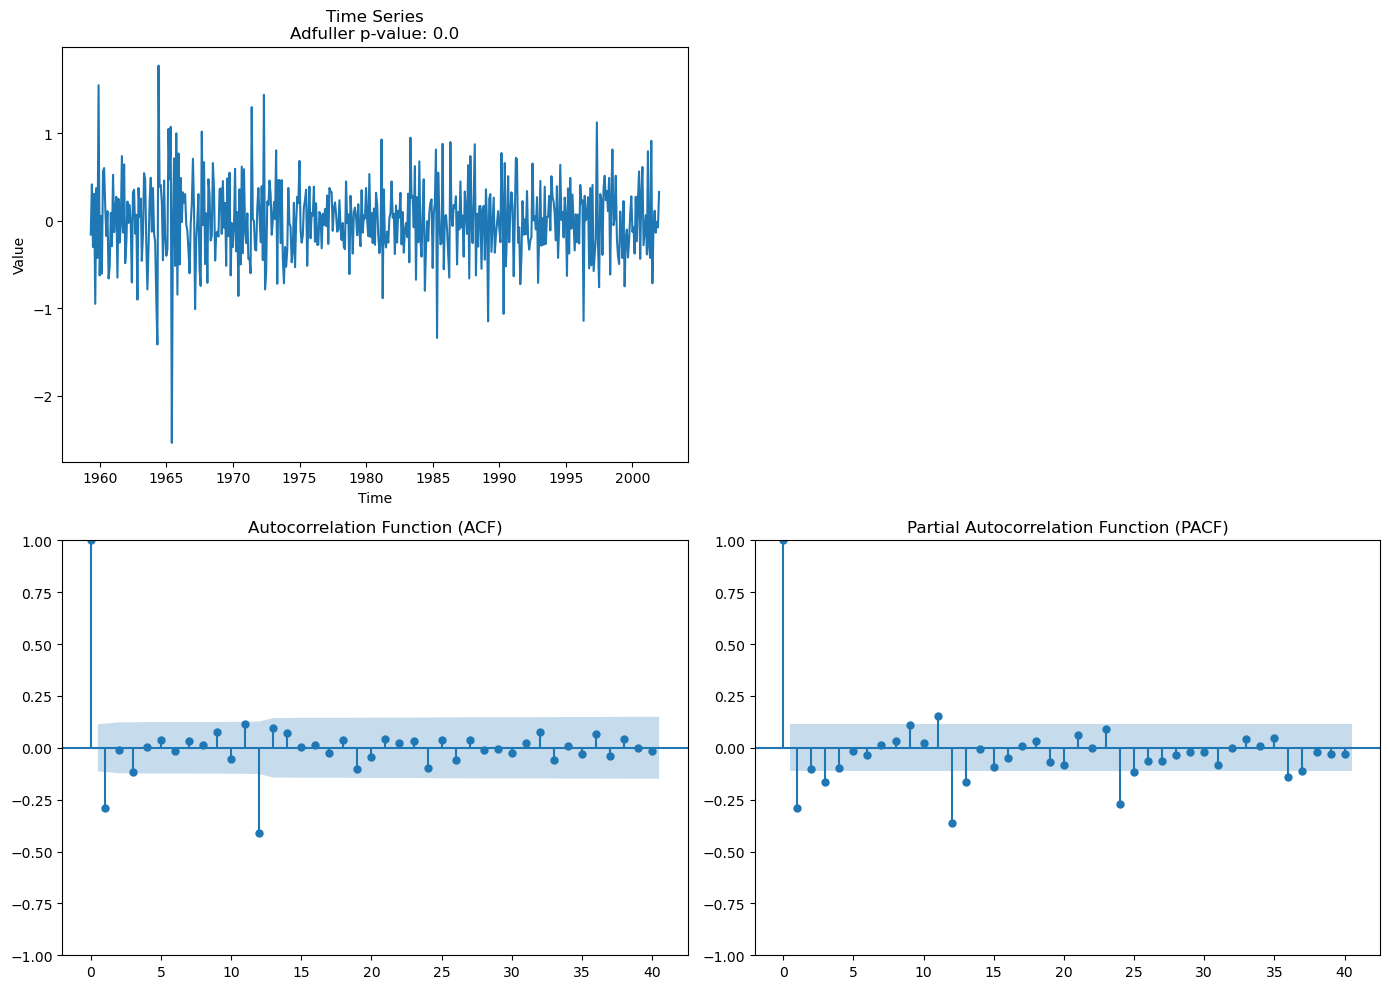

True

In [5]:
# remove the seasonal component
ts_analyser.difference_series(1, rmv_season=12) 
ts_analyser.check_stationarity(signif_=0.05, plot_=True)

In [6]:
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
model2 = ts_analyser.remove_p_val(list(range(1,4)), list(range(1,14)))
model2.summary()

Iteration AIC: 312.45824819135913 vs. full model AIC: 311.8041993183486
Iteration AIC: 309.6778757535395 vs. full model AIC: 311.8041993183486
Iteration AIC: 309.5394519088891 vs. full model AIC: 311.8041993183486
Iteration AIC: 308.0713404717807 vs. full model AIC: 311.8041993183486
Iteration AIC: 309.3156995617341 vs. full model AIC: 311.8041993183486
Iteration AIC: 304.47155261160293 vs. full model AIC: 311.8041993183486
Iteration AIC: 300.9327314977278 vs. full model AIC: 311.8041993183486
Iteration AIC: 300.41030694874223 vs. full model AIC: 311.8041993183486
Iteration AIC: 298.7101653371974 vs. full model AIC: 311.8041993183486
Iteration AIC: 297.5504574996835 vs. full model AIC: 311.8041993183486
Iteration AIC: 296.76402494671686 vs. full model AIC: 311.8041993183486
Iteration AIC: 297.6208595864508 vs. full model AIC: 311.8041993183486


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                    
=======================================================================================
Dep. Variable:                             co2   No. Observations:                  513
Model:             ARIMA(0, 0, [1, 3, 12, 13])   Log Likelihood                -142.810
Date:                         Thu, 26 Sep 2024   AIC                            297.621
Time:                                 12:57:24   BIC                            323.063
Sample:                             04-30-1959   HQIC                           307.593
                                  - 12-31-2001                                         
Covariance Type:                           opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      2.882      0.004       0.001       0.003
ma.L1         -0.3721      0.033    -11.364      0.000      -0.436      -0.308
ma.L3         -0.1013      0.029     -3.542      0.000      -0.157      -0.045
ma.L12        -0.9212      0.041    -22.374      0.000      -1.002      -0.840
ma.L13         0.4040      0.034     11.893      0.000       0.337       0.471
sigma2         0.0961      0.006     17.436      0.000       0.085       0.107
===================================================================================
Ljung-Box (L1) (Q):                   0.59   Jarque-Bera (JB):                25.45
Prob(Q):                              0.44   Prob(JB):                         0.00
Heteroskedasticity (H):               0.62   Skew:                            -0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

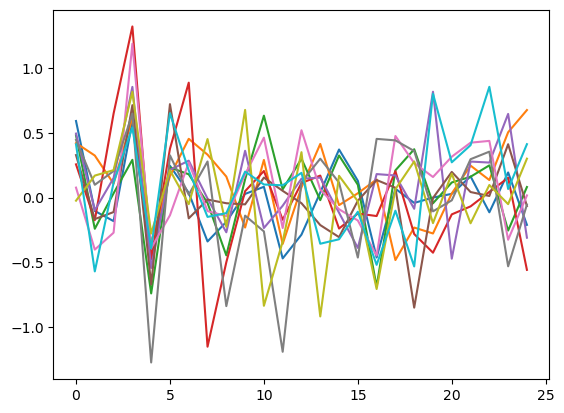

In [7]:
fcsts = ts_analyser.n_forecasts(n_sim=10, n_periods = 25, plot_sample = True)

In [8]:
ts_analyser.exceedance_prob(forecasts=fcsts, threshold=0.7)

array([0.  , 0.  , 0.  , 0.08, 0.08, 0.08, 0.04, 0.  , 0.04, 0.08])